In [1]:
%run 'ks25_Read_epistasis.ipynb'
notebook_prefix = 'ks26'
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)



Reading precalculated epistasis...
/Users/karen/HIS3InterspeciesEpistasis/Analysis/Karen/files_dump/epistasis_in_foursomes/



Variable "ep_dict" is a dictionary. 
Keys are tuples (mutA, mutB) and values are pandas.Series of epistasis between mutA and mutB in all backgrounds.

Function get_ep_summary takes ep_dict as an argumant and applies an arbitrary function to every pd.Series object.

natlib_filtering is currently True. This can be changed in the cell #2.



In [57]:
import scipy
from scipy import stats

### Reading epistasis data

In [83]:
def get_ep_summary(epistasis_dictionary, function):
    floatprogress = FloatProgress(min=0, max=len(epistasis_dictionary))
    display(floatprogress)
    summary_dict = OrderedDict()
    for k,v in epistasis_dictionary.items():
        summary_dict[k] = function(v)
        floatprogress.value += 1
    return summary_dict

In [213]:
def get_fraction_strong(ep_series, strong_epistasis_threshold=0.4):
    strong = ep_series[np.abs(ep_series) > strong_epistasis_threshold]
    return 1. * len(strong) / len(ep_series)

In [215]:
ep_summary_mean = get_ep_summary(ep_dict, np.mean)
ep_summary_median = get_ep_summary(ep_dict, np.median)
ep_summary_std = get_ep_summary(ep_dict, np.std)
ep_summary_skew = get_ep_summary(ep_dict, scipy.stats.skew)

ep_summary_fraction_04 = get_ep_summary(ep_dict, lambda series: get_fraction_strong(series, strong_epistasis_threshold=0.4))
ep_summary_fraction_05 = get_ep_summary(ep_dict, lambda series: get_fraction_strong(series, strong_epistasis_threshold=0.5))

In [220]:
ep_summary = pd.DataFrame.from_items([('epistasis_mean', ep_summary_mean), 
                                      ('epistasis_median', ep_summary_median),
                                     ('epistasis_std', ep_summary_std),
                                     ('epistasis_skew', ep_summary_skew),
                                     ('ep_strong_fraction_04' ,ep_summary_fraction_04),
                                     ('ep_strong_fraction_05' ,ep_summary_fraction_05)])

ep_summary.reset_index(inplace=True)
ep_summary.rename(columns={'level_0':'mutA', 'level_1':'mutB'}, inplace=True)
ep_summary[:2]

,mutA,mutB,epistasis_mean,epistasis_median,epistasis_std,epistasis_skew,ep_strong_fraction_04,ep_strong_fraction_05
0,102K,104L,-0.076168,0.0,0.232586,-0.868850,0.091075,0.066734
1,102K,105H,-0.022907,0.0,0.206599,-1.022725,0.047122,0.038239


### Reading structural information

In [94]:
%run 'ks27_Read_structural_information.ipynb'


Variables: 
- structural_data:		pandas.DataFrame with some structural information,
- get_distance_24mer:		function for getting distances between two positions
				(this also works: get_distance_24mer(13, 'substrate'))
- quantitative_columns_dict:	nice names for some columns in structural_data,
- his3_24mer_file:		path to predicted His3 24mer structure.



In [112]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



In [136]:
%run 'ks21_Read_impacts_of_mutations.ipynb'

Fitness impacts in the form "mutation" : "impacts in all backgrounds" is available as fit_dict

Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



### Merging structural information with epistasis data

In [221]:
position_to_segment = {}
for segment in positions.segment:
    for position in positions.set_index('segment').loc[segment]['positions_Uniprot_P06633']:
        position_to_segment[position] = segment

In [222]:
ep_summary['positionA'] = ep_summary['mutA'].apply(lambda s: int(s[:-1]))
ep_summary['positionB'] = ep_summary['mutB'].apply(lambda s: int(s[:-1]))


ep_summary['segment'] = ep_summary['positionA'].apply(lambda p: position_to_segment[p]) #checking only one position

ep_summary['distance_24mer'] = ep_summary.apply(lambda df: get_distance_24mer(df['positionA'], df['positionB']), axis=1)

ep_summary['ddG_A'] = ep_summary['mutA'].apply(get_ddG)
ep_summary['ddG_B'] = ep_summary['mutB'].apply(get_ddG)
ep_summary['ddG_double'] = ep_summary.apply(lambda df: get_ddG(df['mutA'] + ':' + df['mutB']), axis=1)

ep_summary['mean_fit_impact_A'] = ep_summary['mutA'].apply(lambda m: get_fitness_impact(fit_dict, m, np.mean))
ep_summary['mean_fit_impact_B'] = ep_summary['mutB'].apply(lambda m: get_fitness_impact(fit_dict, m, np.mean))
ep_summary['std_fit_impact_A'] = ep_summary['mutA'].apply(lambda m: get_fitness_impact(fit_dict, m, np.std))
ep_summary['std_fit_impact_B'] = ep_summary['mutB'].apply(lambda m: get_fitness_impact(fit_dict, m, np.std))
ep_summary['mean_fit_impact_A+B'] = ep_summary.apply(lambda df: df['mean_fit_impact_A']+df['mean_fit_impact_B'], axis=1)

ep_summary = ep_summary[~(ep_summary['segment'] == 'S9')]

In [224]:
to_exclude = ['mutA', 'mutB', 'positionA', 'positionB', 'segment']
columns_for_correlation = [c for c in ep_summary.columns if c not in to_exclude]

### Graphs

SpearmanrResult(correlation=-0.09999394935188298, pvalue=7.494791323554979e-05)


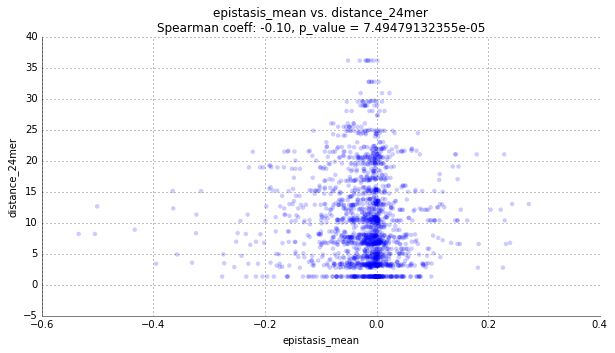

In [156]:
plot_better()
x = 'epistasis_mean'
y = 'distance_24mer'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.2)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

SpearmanrResult(correlation=-0.24330143808345425, pvalue=1.7019767386489396e-22)


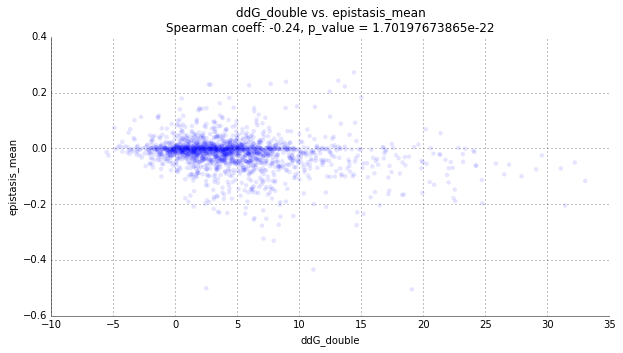

In [157]:
plot_better()
x = 'ddG_double'
y = 'epistasis_mean'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

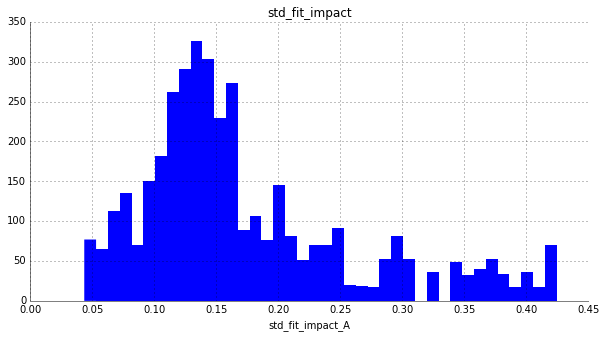

In [162]:
plot_better()
x = 'std_fit_impact_A'
y = 'std_fit_impact_B'

title = '%s' %(x[:-2])
plt.hist(list(ep_summary[x].values) + list(ep_summary[y].values), bins=40,
           edgecolor='none', alpha=1)
plt.title(title)
plt.xlabel(x)

SpearmanrResult(correlation=-0.45801477842398686, pvalue=6.8648798975450899e-82)


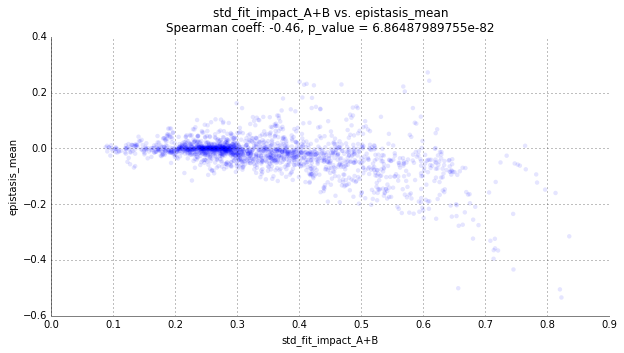

In [180]:
plot_better()
x = 'std_fit_impact_A+B'
y = 'epistasis_mean'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

SpearmanrResult(correlation=-0.41645470996498901, pvalue=1.3157977329988761e-66)


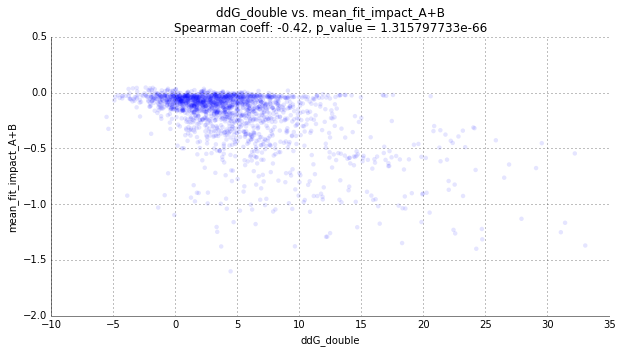

In [185]:
plot_better()
x = 'ddG_double'
y = 'mean_fit_impact_A+B'
title = '%s vs. %s' %(x,y)
statistics = stats.spearmanr(ep_summary.dropna()[x].values, ep_summary.dropna()[y].values)
print statistics
plt.scatter(ep_summary[x], ep_summary[y],
           edgecolor='none', alpha=0.1)
plt.title(title + '\nSpearman coeff: %.2f, p_value = %s' %(statistics[0], statistics[1]))
plt.xlabel(x)
plt.ylabel(y)

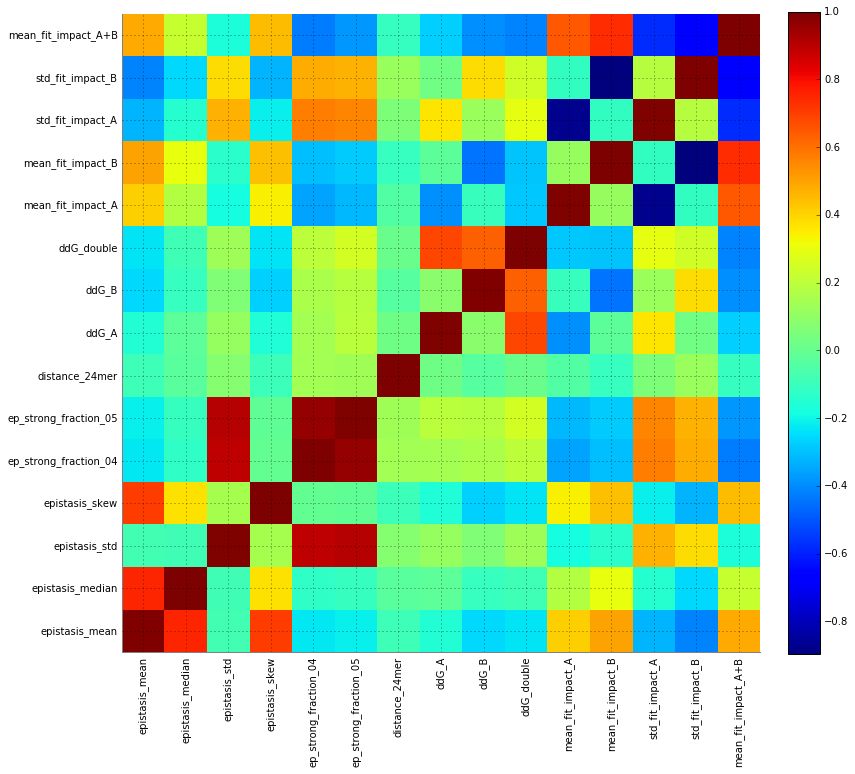

In [230]:
plot_better(width=12, height=12)
fig = plt.imshow(ep_summary[columns_for_correlation].corr(method='spearman'), origin='lower', interpolation='none')
plt.colorbar(fig, fraction=0.046, pad=0.04)
plt.xticks(range(len(columns_for_correlation)), columns_for_correlation, rotation=90, ha='center');
plt.yticks(range(len(columns_for_correlation)), columns_for_correlation, rotation=0, va='center');
plt.tight_layout()

In [229]:
printlist(ep_summary.columns)

mutA
mutB
epistasis_mean
epistasis_median
epistasis_std
epistasis_skew
ep_strong_fraction_04
ep_strong_fraction_05
positionA
positionB
segment
distance_24mer
ddG_A
ddG_B
ddG_double
mean_fit_impact_A
mean_fit_impact_B
std_fit_impact_A
std_fit_impact_B
mean_fit_impact_A+B

